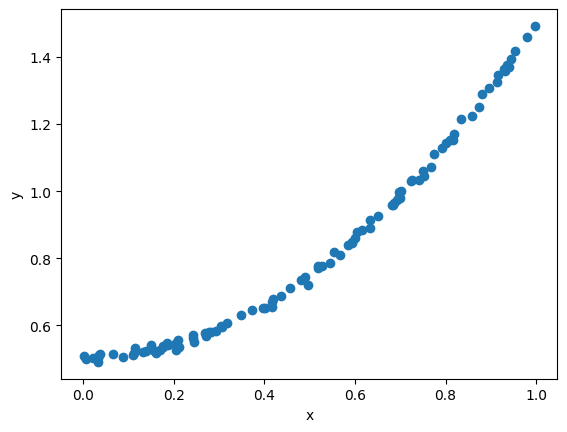

In [5]:
import torch

torch.manual_seed(0)

def generate_data(num_points=100, a=1, b=0.5, noise_factor=0.01):
    # Generate data: 100 points sampled from the quadratic curve listed above
    data_x = torch.rand((1, num_points))
    noise = torch.randn((1, num_points)) * noise_factor
    data_y = a * data_x.square() + b + noise
    return data_x, data_y

data_x, data_y = generate_data()

# Plot the data
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(data_x, data_y);
ax.set_xlabel('x');
ax.set_ylabel('y');

In [6]:
import theseus as th

# data is of type Variable
x = th.Variable(data_x, name="x")
y = th.Variable(data_y, name="y")

# optimization variables are of type Vector with 1 degree of freedom (dof)
a = th.Vector(1, name="a")
b = th.Vector(1, name="b")

In [7]:
def quad_error_fn(optim_vars, aux_vars):
    a, b = optim_vars 
    x, y = aux_vars
    est = a.tensor * x.tensor.square() + b.tensor
    err = y.tensor - est
    return err

optim_vars = a, b
aux_vars = x, y
cost_function = th.AutoDiffCostFunction(
    optim_vars, quad_error_fn, 100, aux_vars=aux_vars, name="quadratic_cost_fn"
)
objective = th.Objective()
objective.add(cost_function)
optimizer = th.DCem(
    objective,
    max_iterations=15,
)
theseus_optim = th.TheseusLayer(optimizer)


DCEM optimizer. Iteration: 0. Error: 38.42743682861328
Nonlinear optimizer. Iteration: 1. Error: 7.387226104736328
Nonlinear optimizer. Iteration: 2. Error: 4.283021926879883
Nonlinear optimizer. Iteration: 3. Error: 1.93190598487854
Nonlinear optimizer. Iteration: 4. Error: 0.49066177010536194
Nonlinear optimizer. Iteration: 5. Error: 0.03877316787838936
Nonlinear optimizer. Iteration: 6. Error: 0.004123837687075138
Nonlinear optimizer. Iteration: 7. Error: 0.006086754612624645
Nonlinear optimizer. Iteration: 8. Error: 0.03924490883946419
Nonlinear optimizer. Iteration: 9. Error: 0.055333495140075684
Nonlinear optimizer. Iteration: 10. Error: 0.010837509296834469
Nonlinear optimizer. Iteration: 11. Error: 0.014032606966793537
Nonlinear optimizer. Iteration: 12. Error: 0.0057152025401592255
Nonlinear optimizer. Iteration: 13. Error: 0.005325776059180498
Best solution: {'a': tensor([[0.9933]]), 'b': tensor([[0.5008]])}


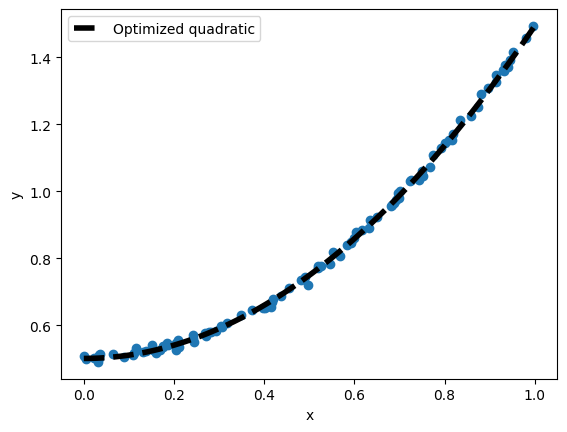

In [8]:
theseus_inputs = {
"x": data_x,
"y": data_y,
"a": 2 * torch.ones((1, 1)),
"b": torch.ones((1, 1))
}
with torch.no_grad():
    updated_inputs, info = theseus_optim.forward(
        theseus_inputs, optimizer_kwargs={"track_best_solution": True, "verbose":True})
print("Best solution:", info.best_solution)

# Plot the optimized function
fig, ax = plt.subplots()
ax.scatter(data_x, data_y);

a = info.best_solution['a'].squeeze()
b = info.best_solution['b'].squeeze()
x = torch.linspace(0., 1., steps=100)
y = a*x*x + b
ax.plot(x, y, color='k', lw=4, linestyle='--',
        label='Optimized quadratic')
ax.legend()

ax.set_xlabel('x');
ax.set_ylabel('y');